# DRL Analysis
##### David M. Freestone & Fuat Balci
March 14, 2016

### 1.0 Introduction

This jupyter notebook shows how to analyze the data collected using the Psychopy DRL experiment accompanying xxx (the chapter).

First, we need to tell Python what packages and functions we'll use in this analysis script. They come in the form of import statements

In [1]:
from glob import glob     # for finding data files
from os.path import join  # for dealing with path names easily

from pandas import read_csv, concat, isnull     # reading in the data
from scipy.stats import invgauss, expon # useful distributions
from scipy.optimize import minimize     # gradient descent fitting
from numpy import log, sqrt, hstack     # some math functions

from matplotlib.pyplot import subplots, style  # for plotting
style.use("fivethirtyeight")                   # set figure style

# Import entire packages, so we can explore later.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Needed so plots show up in the jupyter notebook
%matplotlib inline

# Matplotlib spits out an annoying FutureWarning that we don't care about.
# Suppress it
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

Next we define the data directory, find all the ".csv" files in the directory, and load them all into a pandas DataFrame

In [4]:
!pwd

/Users/freestoned/Dropbox (William Paterson)/3-lab/users/david/collaborations/timing_tasks/experiment/DRL procedure


In [5]:
data_directory = "data"
data_files = glob(join(data_directory, "*.csv"))
data = concat([read_csv(f) for f in data_files])

There are a lot of columns in this dataset that we'll probably never use (i.e., frameRate). It makes looking at the data easier if we remove them.

We'll also remove any event that isn't a response (like the introduction and break screens).

In [7]:
columns = ["participant", "session", "date", "time", 
           "block_number", "interval", "response_number", "rt", "score"]
response_idx = data.response_number > 0
data = data.loc[response_idx, columns]

### 2.0 Summary measures

##### 2.1 Summary statistics

In [8]:
group = ["participant", "session"]
data.groupby(group).rt.describe()

,,count,mean,std,min,25%,50%,75%,max
participant,session,,,,,,,,
100,1,672.0,5.325523,1.621950,0.083063,4.538231,5.287835,6.044722,15.716411
101,1,481.0,7.432690,2.501031,0.183546,6.089978,7.124061,8.276821,38.463036
102,1,592.0,6.043880,3.420222,0.002172,4.537827,5.455670,6.599852,30.748147
103,1,544.0,6.589998,3.126120,0.150752,4.916805,6.174057,8.059135,27.895422
104,1,592.0,6.053245,2.862583,0.003070,4.781319,6.165405,7.508505,19.785809
105,1,562.0,6.360542,2.305449,0.065485,5.092544,6.088851,7.275466,25.159840


In [9]:
data.groupby(group).rt.agg(["mean", "std", "sem"])

,,mean,std,sem
participant,session,,,
100,1,5.325523,1.621950,0.062568
101,1,7.432690,2.501031,0.114037
102,1,6.043880,3.420222,0.140570
103,1,6.589998,3.126120,0.134031
104,1,6.053245,2.862583,0.117651
105,1,6.360542,2.305449,0.097249


##### 2.2 Scatter Plots

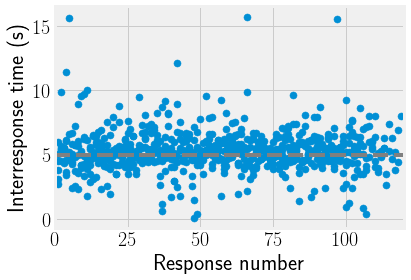

In [59]:
idx = data.participant==100
x = data[idx].response_number
y = data[idx].rt

fig, ax = subplots()
ax.scatter(x, y, s=50)
ax.hlines(data[idx].interval, 0, 1+x.max(),
          linestyle="--", color="gray")

# Modify the axes
ax.set_xlim((0, 1+x.max()))
ax.set_xlabel("Response number", fontsize=22)
ax.set_ylabel("Interresponse time (s)", fontsize=22)
ax.tick_params(labelsize=20)
fig.tight_layout()

fig.savefig("Figure9a.pdf", transparent=True)

##### 2.3 Histograms

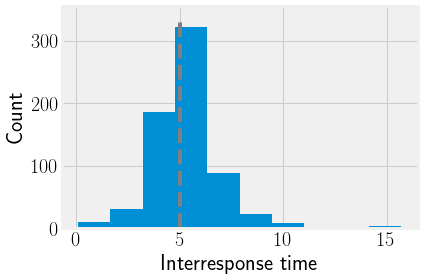

In [60]:
# Plot a histogram of the response times
ax = data[data.participant==100].rt.hist();

# plot a line at the DRL schedule
ymin, ymax = ax.get_ylim()
ax.vlines(5, ymin, ymax, 
          linestyle="--", color="gray")

# Label the x and y axes, and change the tick label size
ax.set_xlabel("Interresponse time", fontsize=22)
ax.set_ylabel("Count", fontsize=22)
ax.tick_params(labelsize=20)

plt.gcf().tight_layout()   # have to get the current figure because we didn't create a figure handle above.
plt.gcf().savefig("Figure9b.pdf", transparent=True)

### 3.0 Fitting the interresponse time distribution

In humans, the interresponse time is often close to normally distributed, although an inverse gaussian distribution is slightly better. In rats, there are often many "untimed" responses that follow an exponential distribution.

While we probably don't need to fit a mixture distribution here, we do so for the purposes of this tutorial.

The interresponse time distribution is a mixture of "timed" and "untimed" interresponse times, with some fraction ($p$) coming from the timed distribution (inverse gaussian) and the other fraction ($1-p$) coming from an exponential.

$$p(x) = pIG(x; \mu, \lambda_{IG}) + (1-p)\lambda e^{-\lambda_{e}t}$$

where 

$$IG(x; \mu, \lambda_{IG}) = \sqrt{\frac{\lambda_{IG}}{2\pi x^3}}e^{\frac{\lambda_{IG}(x-\mu)^2}{2\mu^2x}}$$

and 

$$\lambda_{IG} = \frac{\mu}{\gamma^2}$$

where $\gamma$ is the weber fraction.

##### 3.1 Estimate the parameters

In [14]:
from scipy.stats import invgauss, expon # import the two functions we need
IGpdf = invgauss.pdf
exppdf = expon.pdf

def expIG(x, p, μ, λ_IG, λ_e):
    """Return the expIG evaluated at x
        Note that this is in "standardized form
        so that mu = μ\λ_IG.
    """
    return p*IGpdf(x, mu=μ/λ_IG, scale=λ_IG) + (1-p)*exppdf(x, λ_e)

def weber(μ, λ):
    return sqrt(μ/λ)

Now we can use gradient descent algorithms to get the maximum likely parameters of the expIG mixture distribution. We'll use the "Nelder-Mead" simplex method because it does not require estimating the likelihood function. The drawback to this method is that constraining the parameters is not a straightforward issue. We'll use the simplest method, because its good enough for our purposes.

In [15]:
def log_likelihood(params, x):
    """Return the log likelihood of x"""
    p, μ, λ_IG, λ_e = params
    
    return log(expIG(x, p, μ, λ_IG, λ_e)).sum()

def negative_llk(params, x):
    """Return the negative log-likelihood of x
        or 100000 (a really big number) if the 
        constraints are not met
    """
    if constraints(params):
        return -log_likelihood(params, x)
    else:
        return 100000
    
def constraints(params):
    """Return True if the constraints are met, else False"""
    p, μ, λ_IG, λ_e = params
    if (p < 0) or (p > 1): return False
    if μ < 0: return False
    if λ_IG < 0: return False
    if λ_e < 0: return False
    return True

def fit(D, p0):
    """Return the fitted params, 
        plus the -LLK and whether the fit succeeded
    """
    result = minimize(negative_llk, p0, args=D, method="Nelder-Mead")
    return hstack((result.x, result.fun, result.success))

Now we'll fit each participant, pooling over sessions, and add the weber fraction ($\gamma$) to the results

In [27]:
initial_estimate = [0.9, 5, 100, 100]

# Do the fitting on each participant.
fit_results = data.groupby("participant").rt.apply(fit, initial_estimate)

# Prettify the DataFrame
fit_results = fit_results.apply(pd.Series)
fit_results.columns = ["p", "μ", "λ_IG", "λ_e", "negLLK", "Success"]

# Add the weber fraction to the DataFrame
fit_results["γ"] = weber(fit_results["μ"], fit_results["λ_IG"])

##### 3.2 Visualizing the fits

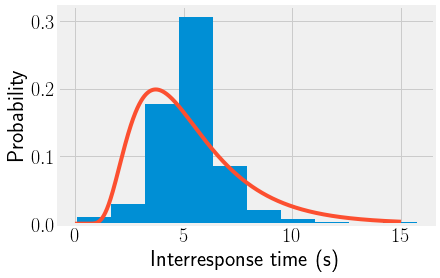

In [26]:
participant = 100
# Pull out the parameters for one participant (and convert to a matrix)
params = fit_results.loc[participant, ["p", "μ", "λ_IG", "λ_e"]].as_matrix()

x = np.linspace(0, 15, 1000)

rt = data[data.participant==participant].rt.as_matrix()
rt_fit = expIG(x, *params)

# Plot
fig, ax = subplots()
ax.hist(rt, bins=10, normed=True);
ax.plot(x, rt_fit)

# Modify the axes
ax.set_xlabel("Interresponse time (s)", fontsize=22)
ax.set_ylabel("Probability", fontsize=22)
ax.tick_params(labelsize=20)

### 4.0 Assessing Optimality

We assume optimal behavior is to maximize the reward rate. The reward rate on this task is the probability of obtaining a reward divided by the time between rewards:

$$\frac{p(R)}{\mu}$$

where 

$$p(R) = p(t>T)$$

that is, the probability of a reward is just the fraction of trials in which the interresponse time $t$ was greater than the DRL schedule $T$. Assuming the timed portion of the interresponse time distribution follows an inverse gaussian, the probability of a reward is

$$= 1-p(t\le T)$$

$$= 1-IG_{cdf}(T; \mu, \lambda_{IG})$$

So that the expected reward rate is:
$$E[r] = \frac{1-IG_{cdf}(T; \mu, \lambda_{IG})}{\mu}$$


In [20]:
IGcdf = invgauss.cdf
def p_reward(T, μ, γ):
    λ_IG = μ/(γ**2)
    return 1 - IGcdf(T, mu=μ/λ_IG, scale=λ_IG)

def reward_rate(T, μ, γ):
    return p_reward(T, μ, γ) / μ

The optimal reward rate is the mean interresponse time that maximizes the reward rate

$$\mathrm{argmax}_\mu E[r; \gamma]$$

The notation shows the dependence of $\gamma$. This equation gives the reward maximizing relationship between $\mu$ and $\gamma$. Because its a function of $\gamma$, the reward maximizing strategy is a infinite set of points that lay along an "optimal performance curve" ($OPC$).

In [21]:
def optimal(T, γ):
    """Return the optimal mean interresponse time given γ"""
    μ, γ = np.meshgrid(np.linspace(0, 3*T, 1000), γ)
    r = reward_rate(T, μ, γ)

    # The first few γ values have to be thrown out because there's no good way to get the
    # reward rate at very low γ.
    idx = ~np.isnan(r).all(axis=1)
    γ = γ[idx, :]
    r = r[idx, :]
    return (μ[0, np.nanargmax(r, axis=1)], 
            np.nanmax(r, axis=1))

The reward rate grows over $\mu$ because the probability of a reward grows as the mean interresponse time grows. But the reward rate shrinks over $\mu$ because the time between rewards grows as the mean interresponse time grows. The $\mu$ at which their influences cross is the reward maximizing interresponse time. This depends on the participant's timing variability $\gamma$ because $\gamma$ governs the rate at which the probability of a reward grows over $\mu$.

Here is a plot of the reward rate for different values of $\gamma$. We also plot the Optimal Performance Curve (in black) that shows the reward rate earned for an optimal participant, given their timing variability $\gamma$.

/Users/freestoned/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/freestoned/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1732: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/freestoned/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/Users/freestoned/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freestoned/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing

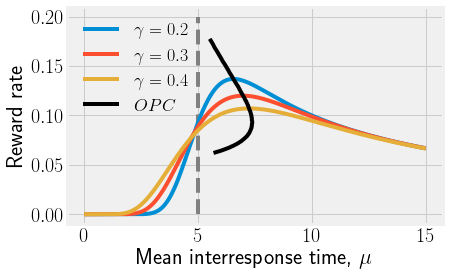

In [22]:
T = 5
μ = np.linspace(0, 15, 1000)

plt.rc('text', usetex=True)
fig, ax = subplots()

ax.vlines(T, 0, 0.2, linestyle="--", color="gray")

ax.plot(μ, reward_rate(T, μ, 0.2), label=r"$\gamma = 0.2$")
ax.plot(μ, reward_rate(T, μ, 0.3), label=r"$\gamma = 0.3$")
ax.plot(μ, reward_rate(T, μ, 0.4), label=r"$\gamma = 0.4$")

μ_opt, r_opt = optimal(5, np.linspace(0, 1.2, 100))
ax.plot(μ_opt, r_opt, color='k', label="$OPC$")

ax.legend(loc="best", fontsize=18, framealpha=0)
ax.set_xlabel("Mean interresponse time, $\mu$", fontsize=22)
ax.set_ylabel("Reward rate", fontsize=22)
ax.tick_params(labelsize=20)

##### 3.1 Are the participants optimal?

To assess the degree to which the participants are optimal, we have to find the optimal mean interresponse time per participant, and then compare it to their actual mean interresponse time.

In [25]:
fit_results

,p,μ,λ_IG,λ_e,negLLK,Success,γ
participant,,,,,,,
100,1.0,5.325522,21.707449,110.547291,1548.725988,1.0,0.495310
101,1.0,7.432691,26.429371,108.715804,1303.681504,1.0,0.530310
102,0.9,5.000000,100.000000,100.000000,inf,0.0,0.223607
103,1.0,6.589937,7.104024,115.891287,1649.222676,1.0,0.963138
104,0.9,5.000000,100.000000,100.000000,inf,0.0,0.223607
105,1.0,6.360554,15.964247,128.294560,1516.446718,1.0,0.631209


Remove the subjects that did not converge (or, track down the reason why they didn't)

In [33]:
γ = fit_results.γ.as_matrix()
μ = fit_results.μ.as_matrix()
r = reward_rate(5, μ, γ)

μ_opt, r_opt = optimal(5, γ)

distance_from_optimal = μ / μ_opt
proportion_maximum_gain = r / r_opt

/Users/freestoned/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/freestoned/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1732: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/freestoned/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


Now plot these two measures over participants where fits were obtained

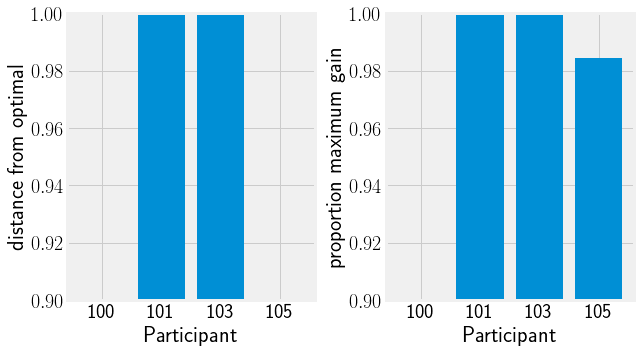

In [49]:
participants = fit_results.index.values
nparticipants = len(participants)

fig, ax = subplots(ncols=2, figsize=(9,5))
ax_dist, ax_prop = ax

# Plot the distance from optimal measure.
ax_dist.bar(range(0,nparticipants), distance_from_optimal, align="center");
ax_dist.set_ylabel("distance from optimal", fontsize=22)

# Plot the distance from optimal measure.
ax_prop.bar(range(0,nparticipants), proportion_maximum_gain, align="center");
ax_prop.set_ylabel("proportion maximum gain", fontsize=22)

# Mofidy both axes at the same time.
for a in ax:
    a.set_xticks(range(0, nparticipants))
    a.set_xticklabels(participants)
    a.set_ylim((0.9, 1))
    a.set_xlabel("Participant", fontsize=22)
    a.tick_params(labelsize=20)
fig.tight_layout()